In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

# Lectura de datos

In [3]:
estacionesZona = 'https://github.com/MoisesC04/Cartografia_Digital/raw/main/Datos_Excel/Datos_Estaciones.xlsx'
EstacionesIDEAM = pd.read_excel(estacionesZona)
#EstacionesIDEAM.head()
EstacionesIDEAM['Fecha'] = pd.to_datetime(EstacionesIDEAM['Fecha'])

## Filtros necesarios

In [4]:
# Filtrar los datos en el rango de años deseado (2000-2019)
filtro_fecha = (EstacionesIDEAM['Fecha'] >= '2000-01-01') & (EstacionesIDEAM['Fecha'] <= '2019-12-31')

# Lista de las estaciones seleccionadas
estaciones_seleccionadas = ['CASA DE ZINC [22020040]','GUAINI [22060110]','HERRERA [22010010]','MESA DE POLE [22055020]',
                            'RELATOR [22015020]', 'SAN PEDRO [22050070]', 'SANTIAGO PEREZ [22020050]',
                            'GAITAN [22010070]', 'LIMON EL [22045020]']

# Filtrar los datos para incluir solo las estaciones seleccionadas
FiltroEA = EstacionesIDEAM[EstacionesIDEAM['NombreEstacion'].isin(estaciones_seleccionadas) & filtro_fecha]

precipitaciones_anuales = FiltroEA.groupby([FiltroEA['NombreEstacion'], FiltroEA['Fecha'].dt.year])['Valor'].sum().unstack()
precipitaciones_mensuales = FiltroEA.groupby([FiltroEA['NombreEstacion'], FiltroEA['Fecha'].dt.month])['Valor'].sum().unstack()
precipitaciones_mensualesAño = FiltroEA.pivot_table(index='NombreEstacion', columns=FiltroEA['Fecha'].dt.strftime('%Y-%m'), values='Valor', aggfunc='sum', fill_value=0)

# Graficas Precipitación Puntuales

## Gráfica anual de las precipitaciones por estación

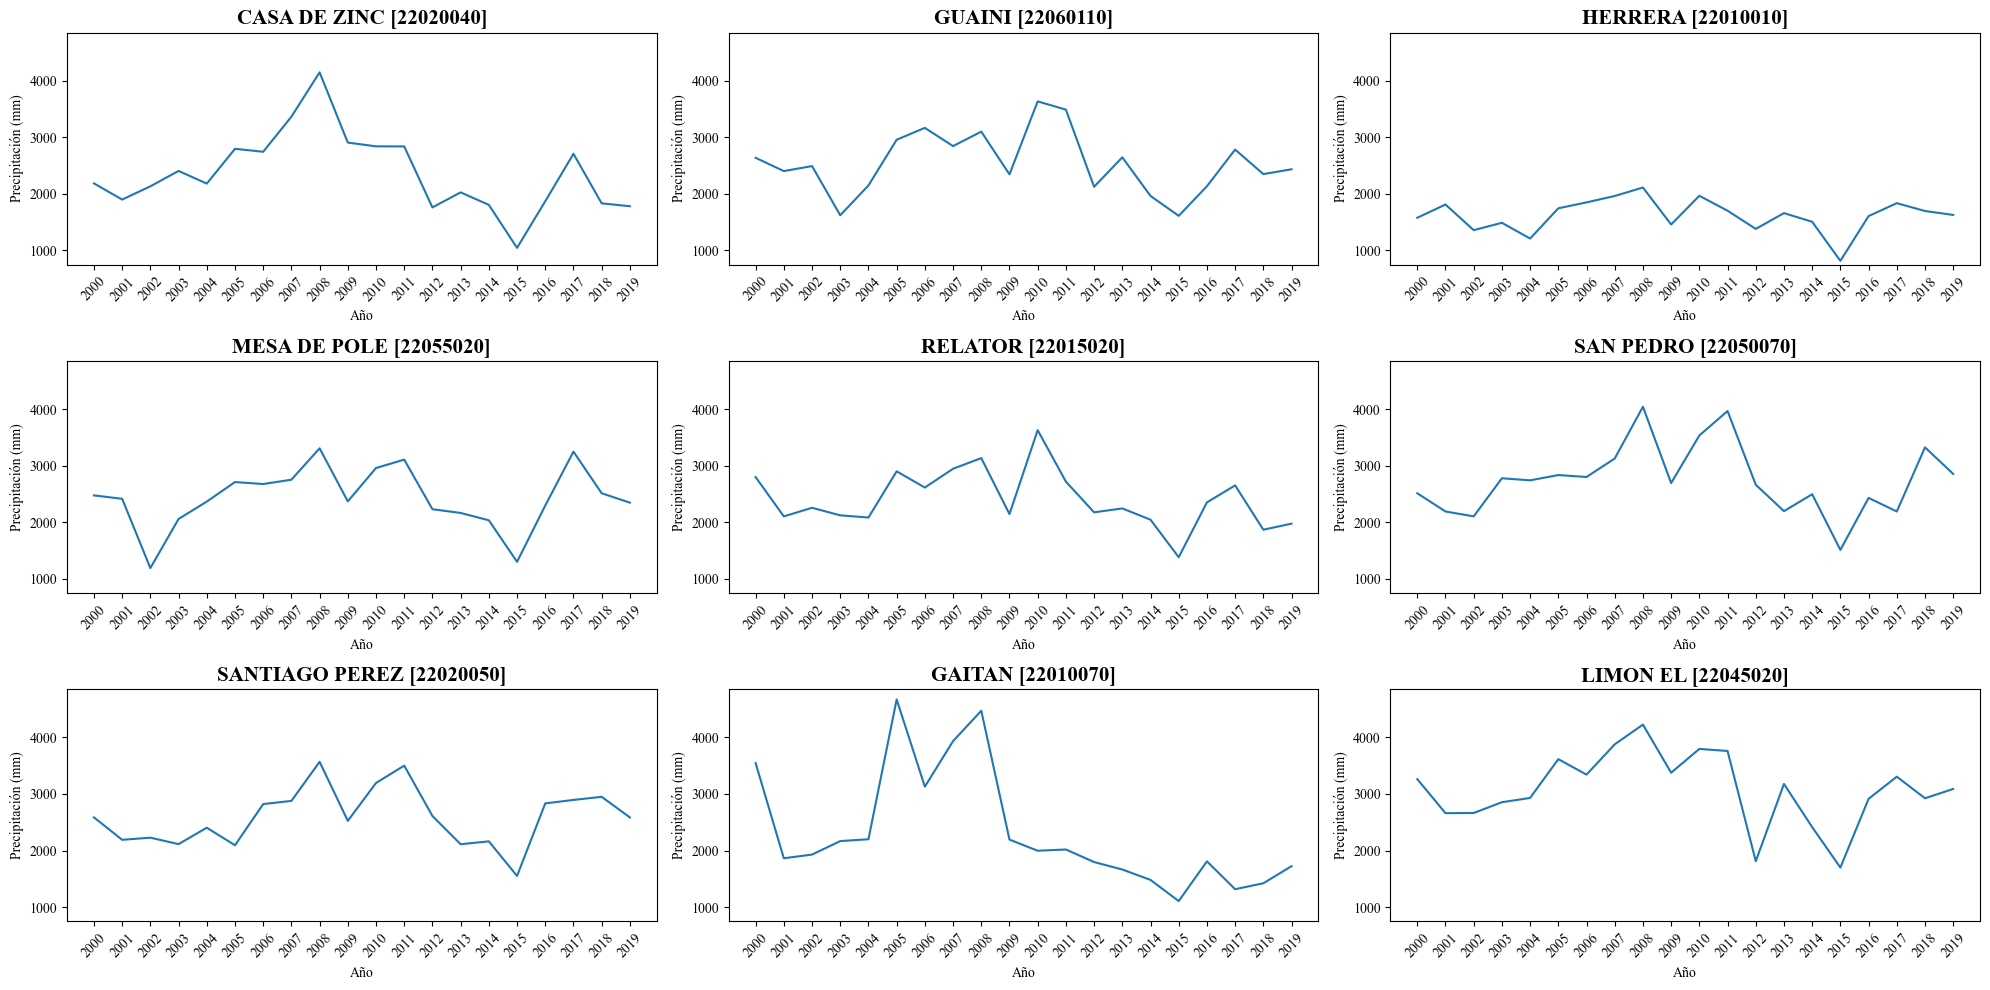

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

# Inicializar límites comunes del eje Y para todos los subplots
y_lim_max = None
y_lim_min = None

for i in range(len(estaciones_seleccionadas)):
    datos_estacion = precipitaciones_anuales.loc[estaciones_seleccionadas[i]]
    ax = axes[i // 3, i % 3]
    ax.set_title(estaciones_seleccionadas[i], fontname='Times New Roman', fontsize=15, fontweight='bold')

    # Crear el gráfico de líneas con el eje X como años y el eje Y como precipitaciones.
    x = range(len(datos_estacion))
    y = datos_estacion.values
    ax.plot(x, y, label='Precipitación')

    etiquetas_x = datos_estacion.index
    ax.set_xticks(x)
    ax.set_xticklabels(etiquetas_x, rotation=45, fontname='Times New Roman', fontsize=10)
    
    # Establecer fuente y tamaño de fuente para las etiquetas del eje Y
    for label in ax.get_yticklabels():
        label.set_fontname('Times New Roman')
        label.set_fontsize(10)

    ax.set_xlabel('Año', fontname='Times New Roman', fontsize=10)
    ax.set_ylabel('Precipitación (mm)', fontname='Times New Roman', fontsize=10)

    # Actualizar los límites del eje Y para mantener el mismo rango en todos los subplots
    cur_y_lim = ax.get_ylim()
    if y_lim_max is None or cur_y_lim[1] > y_lim_max:
        y_lim_max = cur_y_lim[1]
    if y_lim_min is None or cur_y_lim[0] < y_lim_min:
        y_lim_min = cur_y_lim[0]

# Aplicar los mismos límites del eje Y a todos los subplots
for i in range(len(estaciones_seleccionadas)):
    axes[i // 3, i % 3].set_ylim(y_lim_min, y_lim_max)

# Ajusta el espaciado entre los subplots y muestra el gráfico.
plt.tight_layout()
#plt.subplots_adjust(top=1, hspace=0.4, wspace=0.2)
#plt.savefig('Anual_Por_Estacion.png', dpi=500, bbox_inches='tight')
plt.show()

## Gráfica mensual promedio con Std

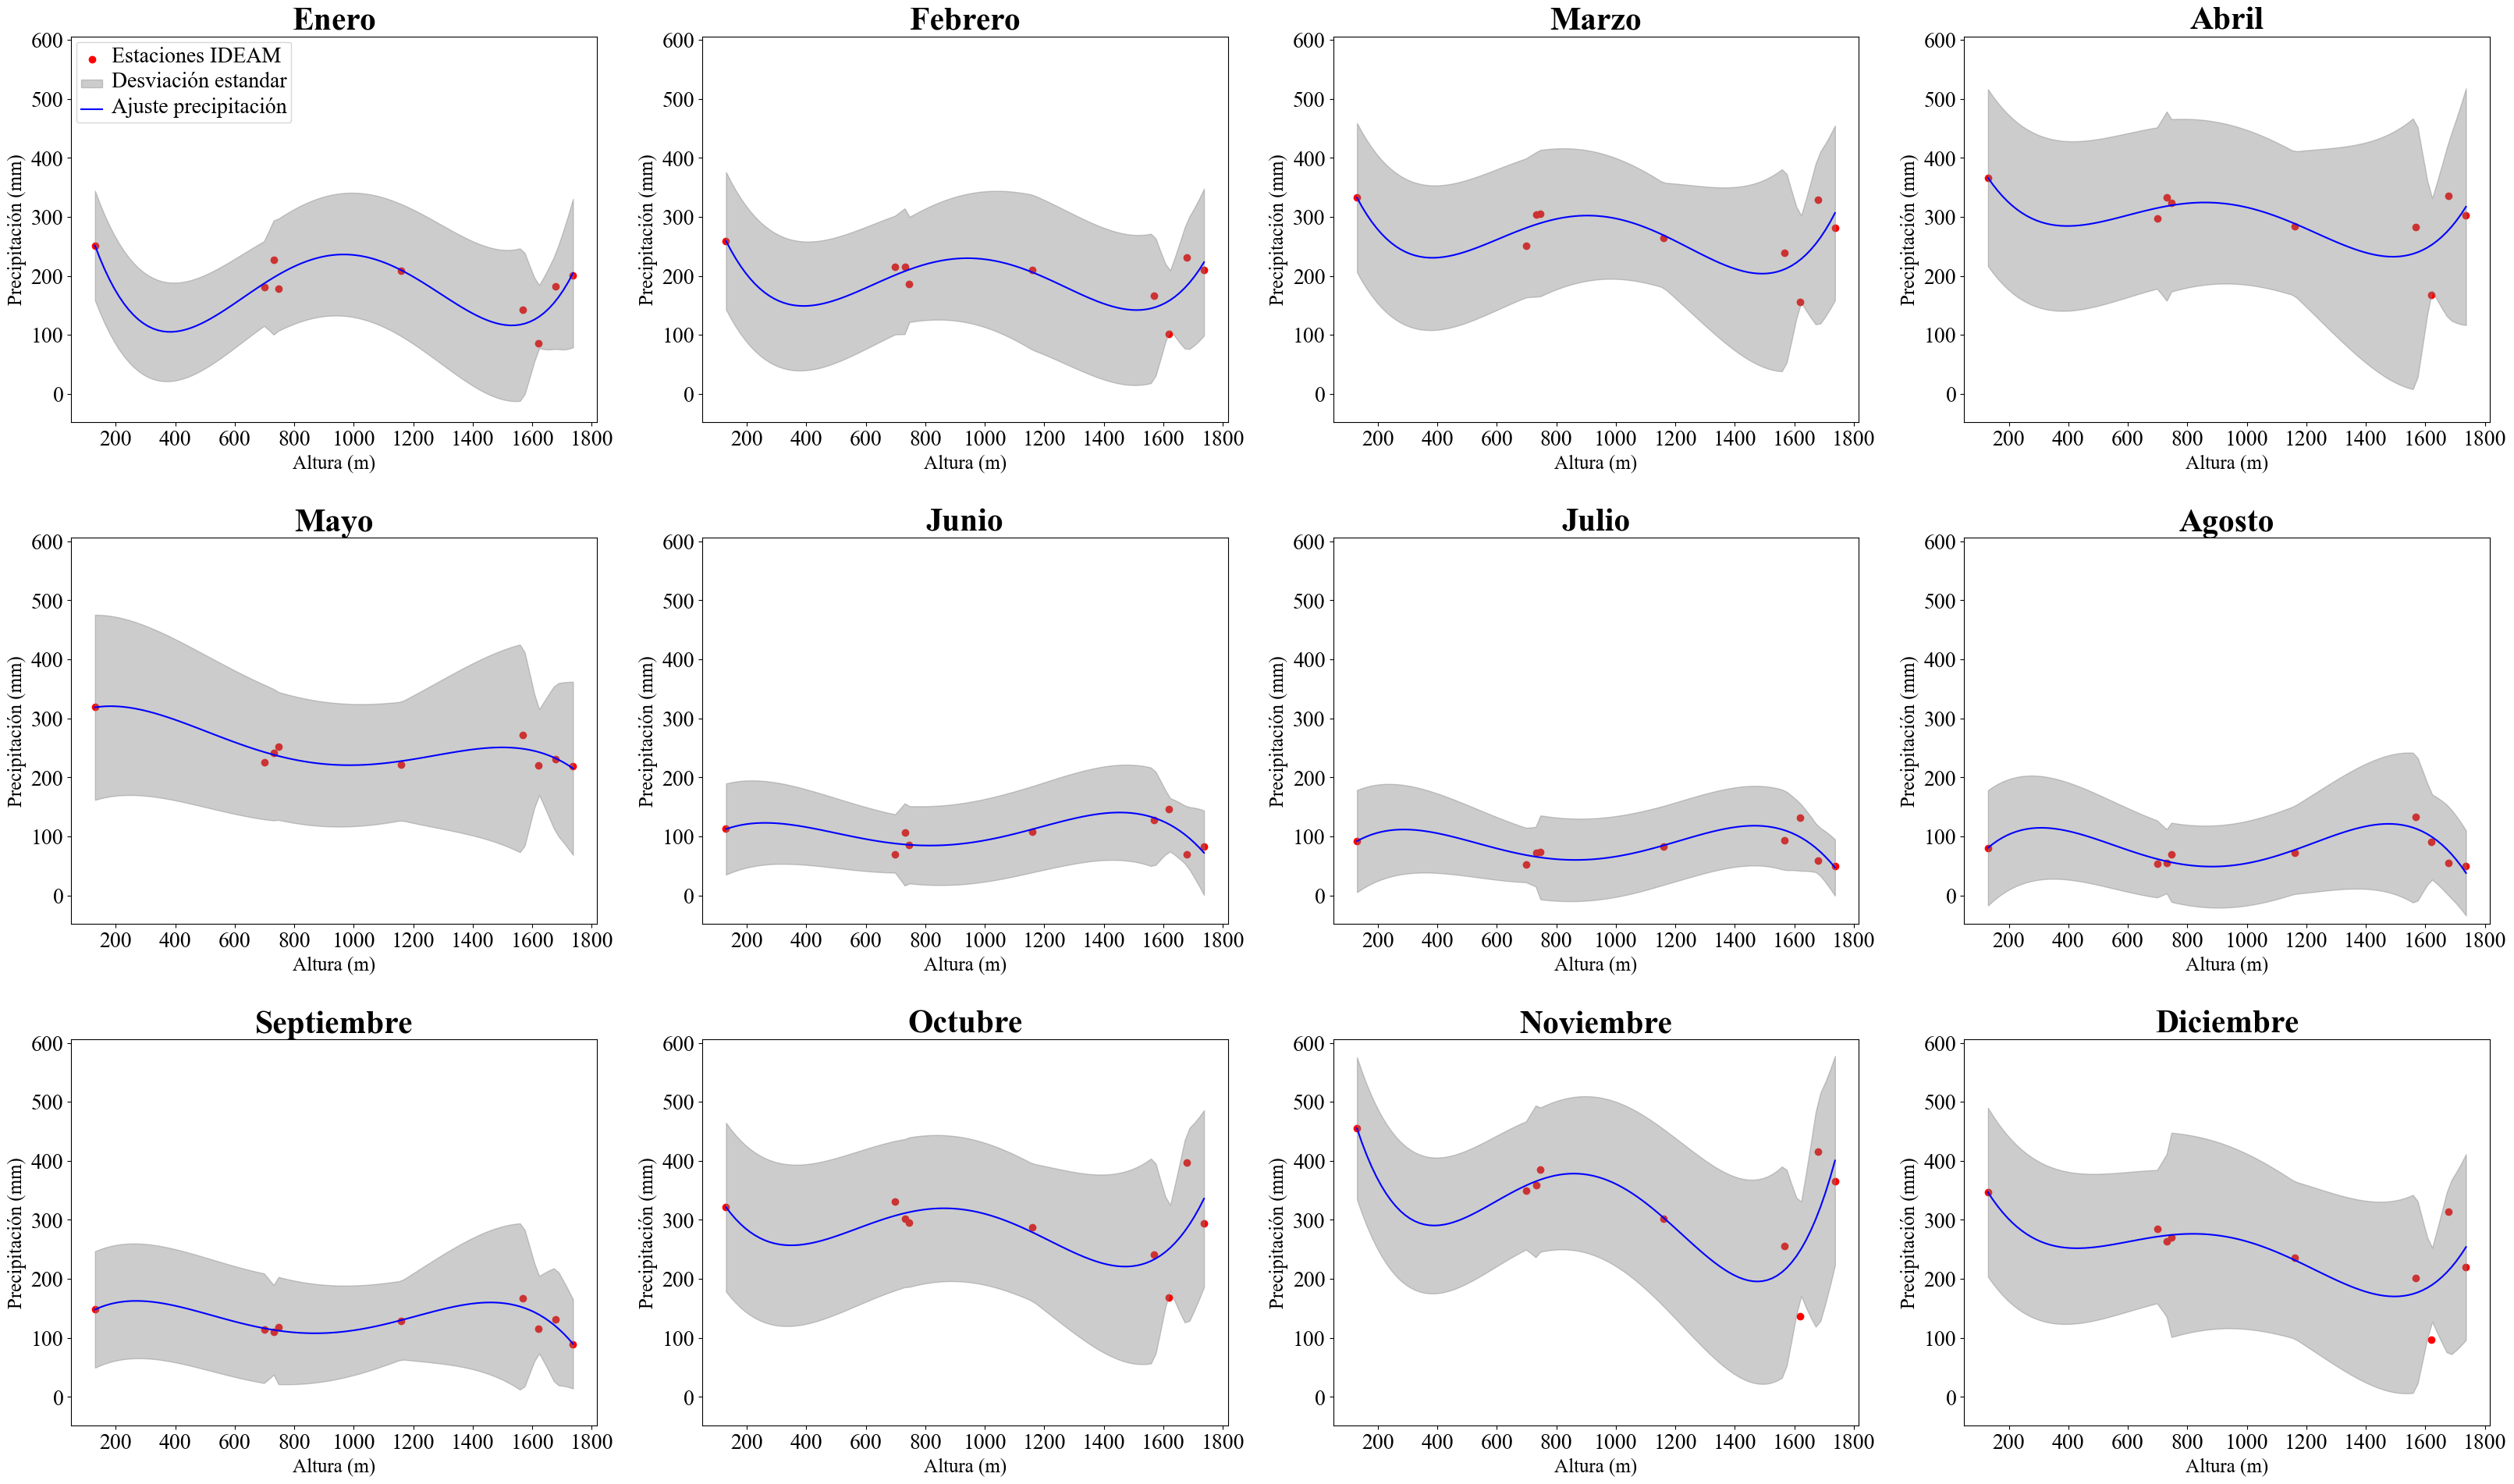

In [42]:
# Listas Pivote
meses = [i for i in range(1, 13)]
meses_L = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']

ordenE = ['LIMON EL [22045020]', 'MESA DE POLE [22055020]', 'SANTIAGO PEREZ [22020050]', 'GUAINI [22060110]',
    'RELATOR [22015020]', 'GAITAN [22010070]', 'HERRERA [22010010]', 'SAN PEDRO [22050070]','CASA DE ZINC [22020040]']
ordenH = [130, 699, 732, 746, 1160, 1568, 1620, 1679, 1737]

prom = {'Enero':[], 'Febrero':[], 'Marzo':[],'Abril':[],'Mayo':[],'Junio':[],'Julio':[],'Agosto':[],'Septiembre':[],'Octubre':[],'Noviembre':[],'Diciembre':[]}
desv = {'Enero':[], 'Febrero':[], 'Marzo':[],'Abril':[],'Mayo':[],'Junio':[],'Julio':[],'Agosto':[],'Septiembre':[],'Octubre':[],'Noviembre':[],'Diciembre':[]}

filtro_por_mesH = {}  # Creamos un diccionario para almacenar los resultados

for mes in meses:
    filtro_por_mesH[f'Mes_{mes}'] = precipitaciones_mensualesAño[precipitaciones_mensualesAño.columns[precipitaciones_mensualesAño.columns.str.endswith(f'-{mes:02d}')]].T

# Itera a través de los DataFrames en el diccionario y reordénalos
for mes in meses:
    act_filtro_por_mesH = filtro_por_mesH[f'Mes_{mes}']
    act_filtro_por_mesH = act_filtro_por_mesH[ordenE]
    filtro_por_mesH[f'Mes_{mes}'] = act_filtro_por_mesH

# Iterar a través de los meses y crear una gráfica para cada mes
for mes_i,mes in enumerate(meses_L):
    datos_mes = filtro_por_mesH[f'Mes_{mes_i + 1}']
    #print(mes_i + 1)
    #print(mes)
    
    promIterador = []
    desvIterador = []
    
    for columnas in datos_mes.columns:
        #print(columnas)
        promIterador.append(datos_mes[columnas].mean())
        desvIterador.append(datos_mes[columnas].std())
        #print('Prom', datos_mes[columnas].mean())
        #print('Desv Est', datos_mes[columnas].std())
        #print('\n\n','-----')
    
    prom[mes] = promIterador
    desv[mes] = desvIterador

########################################################################

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(40, 20))

# Inicializar los límites del eje Y para que se ajusten automáticamente
y_lim_max = None
y_lim_min = None

for mes_i, mes in enumerate(meses_L):
    ax = axes[(mes_i) // 4, (mes_i) % 4]
    ax.set_title(mes, fontname='Times New Roman', fontsize=30, fontweight='bold')

    # Realiza el ajuste del modelo polinómico
    coeffs = np.polyfit(ordenH, prom[mes], 4)

    # Crea un modelo polinómico a partir de los coeficientes
    modelo = np.poly1d(coeffs)
    # Genera puntos en la curva ajustada
    x_fit = np.linspace(130, 1737, 100)
    y_fit = modelo(x_fit)

    ax.scatter(ordenH, prom[mes], label='Estaciones IDEAM', color='red', alpha=1)
    
    # Interpola la desviación estándar para tener la misma cantidad de puntos que x_fit
    desv_interpolada = np.interp(x_fit, ordenH, desv[mes])
    
    # Rellena el área entre la curva y la línea superior e inferior
    ax.fill_between(x_fit, y_fit - desv_interpolada, y_fit + desv_interpolada, color='gray', alpha=0.4, label='Desviación estandar')

    ax.plot(x_fit, y_fit, label='Ajuste precipitación', color='blue')

        # Actualizar los límites del eje Y
    cur_y_lim = ax.get_ylim()
    if y_lim_max is None or cur_y_lim[1] > y_lim_max:
        y_lim_max = cur_y_lim[1]
    if y_lim_min is None or cur_y_lim[0] < y_lim_min:
        y_lim_min = cur_y_lim[0]

    ax.set_xlabel('Altura (m)', fontname='Times New Roman', fontsize=18)
    ax.set_ylabel('Precipitación (mm)', fontname='Times New Roman', fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), fontname='Times New Roman', fontsize=20)

    if mes_i % 4 == 0 and mes_i // 4 == 0:
        legend = ax.legend(loc='upper left')
        for text in legend.get_texts():
            text.set_fontname("Times New Roman")
            text.set_fontsize(20)
        

# Establecer los mismos límites del eje Y para todos los subgráficos
for row in axes:
    for ax in row:
        ax.set_ylim(y_lim_min, y_lim_max)
        # Establecer fuente y tamaño de fuente para el eje Y
        ax.set_yticklabels(ax.get_yticklabels(), fontname='Times New Roman', fontsize=20)
        
        

plt.subplots_adjust(top=1, hspace=0.3, wspace=0.2)

#plt.savefig('FINAL_PromedioDesvMeses.png', dpi=500, bbox_inches='tight')

# Añade una leyenda para mostrar la sombra


## Grafica Anual promedio

# Interpolaciones de precipitaciones

La idea principal era generar interpolaciones espaciales de las precipitaciones, de acuerdo con las estaciones obtenidas, para lograr generar un mapa en donde se observe el fenónmeno de la lluvia espacialmente continuo.

Primero, se intento realizar una interpolación IDW con GRASS GRIS, la cual ejecutó de correctamente, sin embargo, los mapas resultantes no generaron una distribución adecuada y coherente para el fenómeno de precipitación. Por lo tanto, se recurrió a la interpolación Kriging en el mismo software, la cual es un poco más elaborada y requería la instalación de 2 Addons específicos (V.grige y V.kriging), Sin embargo, no se pudo obtener los mapas deseados, ya que en Windows no funcionaban de manera apropiada.

Por lo tanto se realizaron, dos intentos más, el primero utilizando las plataformas R y Rstudio, sin obtener resultados satisfactorios; finalmente, mediante ARC map, se logró realizar las interpolaciones Kriging estandarizadas con un modelo Esférico.

Códigos de GRASS GIS: https://github.com/MoisesC04/Cartografia_Digital/tree/main/C%C3%B3digos_GRASS_Windows

Códigos de ARC GIS: https://github.com/MoisesC04/Cartografia_Digital/tree/main/C%C3%B3digos_ArcGIS

# Determinando el factor R desde las interpolaciones

In [16]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from statistics import mean
import warnings

warnings.filterwarnings('ignore')

## Generando listas pivote

In [17]:
ano = []
mes = []
factorR = []

for i in range(20):
    if i < 10:
        ano.append('PAnual200{}'.format(i))
    else:
        ano.append('PAnual20{}'.format(i))
        
    for j in range(12):
        if j < 9:
            if i < 10:
                mes.append('PMes200{}_0{}'.format(i,j+1))
                factorR.append('FRMes200{}_0{}'.format(i,j+1))
            else:
                mes.append('PMes20{}_0{}'.format(i,j+1))
                factorR.append('FRMes20{}_0{}'.format(i,j+1))
        else:
            if i < 10:
                mes.append('PMes200{}_{}'.format(i,j+1))
                factorR.append('FRMes200{}_{}'.format(i,j+1))
            else:
                mes.append('PMes20{}_{}'.format(i,j+1))
                factorR.append('FRMes20{}_{}'.format(i,j+1))

FactorR_meses = []
meses = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']

for j in range(12):
    FactorR_meses.append(f'FR_{meses[j]}')

## Leyendo rasters localizados en GitHub

### Mapa continuo de precipitiaciones anuales

In [18]:
anoCopia = ano.copy()
anoCopia1 = ano.copy()
anoVc = ano.copy()

for i in range(len(ano)):
    anoCopia[i] = rio.open(f'https://raw.githubusercontent.com/MoisesC04/Cartografia_Digital/main/PrecipitacionAno/{anoCopia[i]}.tif')
    anoCopia1[i] = anoCopia[i].read(1)
    anoVc[i] = anoCopia1[i].ravel()

print('Las precipitaciones anuales continuas estan listas')

Las precipitaciones anuales continuas estan listas


### Mapa continuo de precipitiaciones mensuales

In [19]:
mesCopia = mes.copy()
mesCopia1 = mes.copy()
mesVc = mes.copy()

for i in range(len(mes)):
    mesCopia[i] = rio.open(f'https://raw.githubusercontent.com/MoisesC04/Cartografia_Digital/main/PrecipitacionMes/{mesCopia[i]}.tif')
    mesCopia1[i] = mesCopia[i].read(1)
    mesVc[i] = mesCopia1[i].ravel()
print('Las precipitaciones mensuales continuas estan listas')

Las precipitaciones mensuales continuas estan listas


## Graficando interpolaciones Anuales

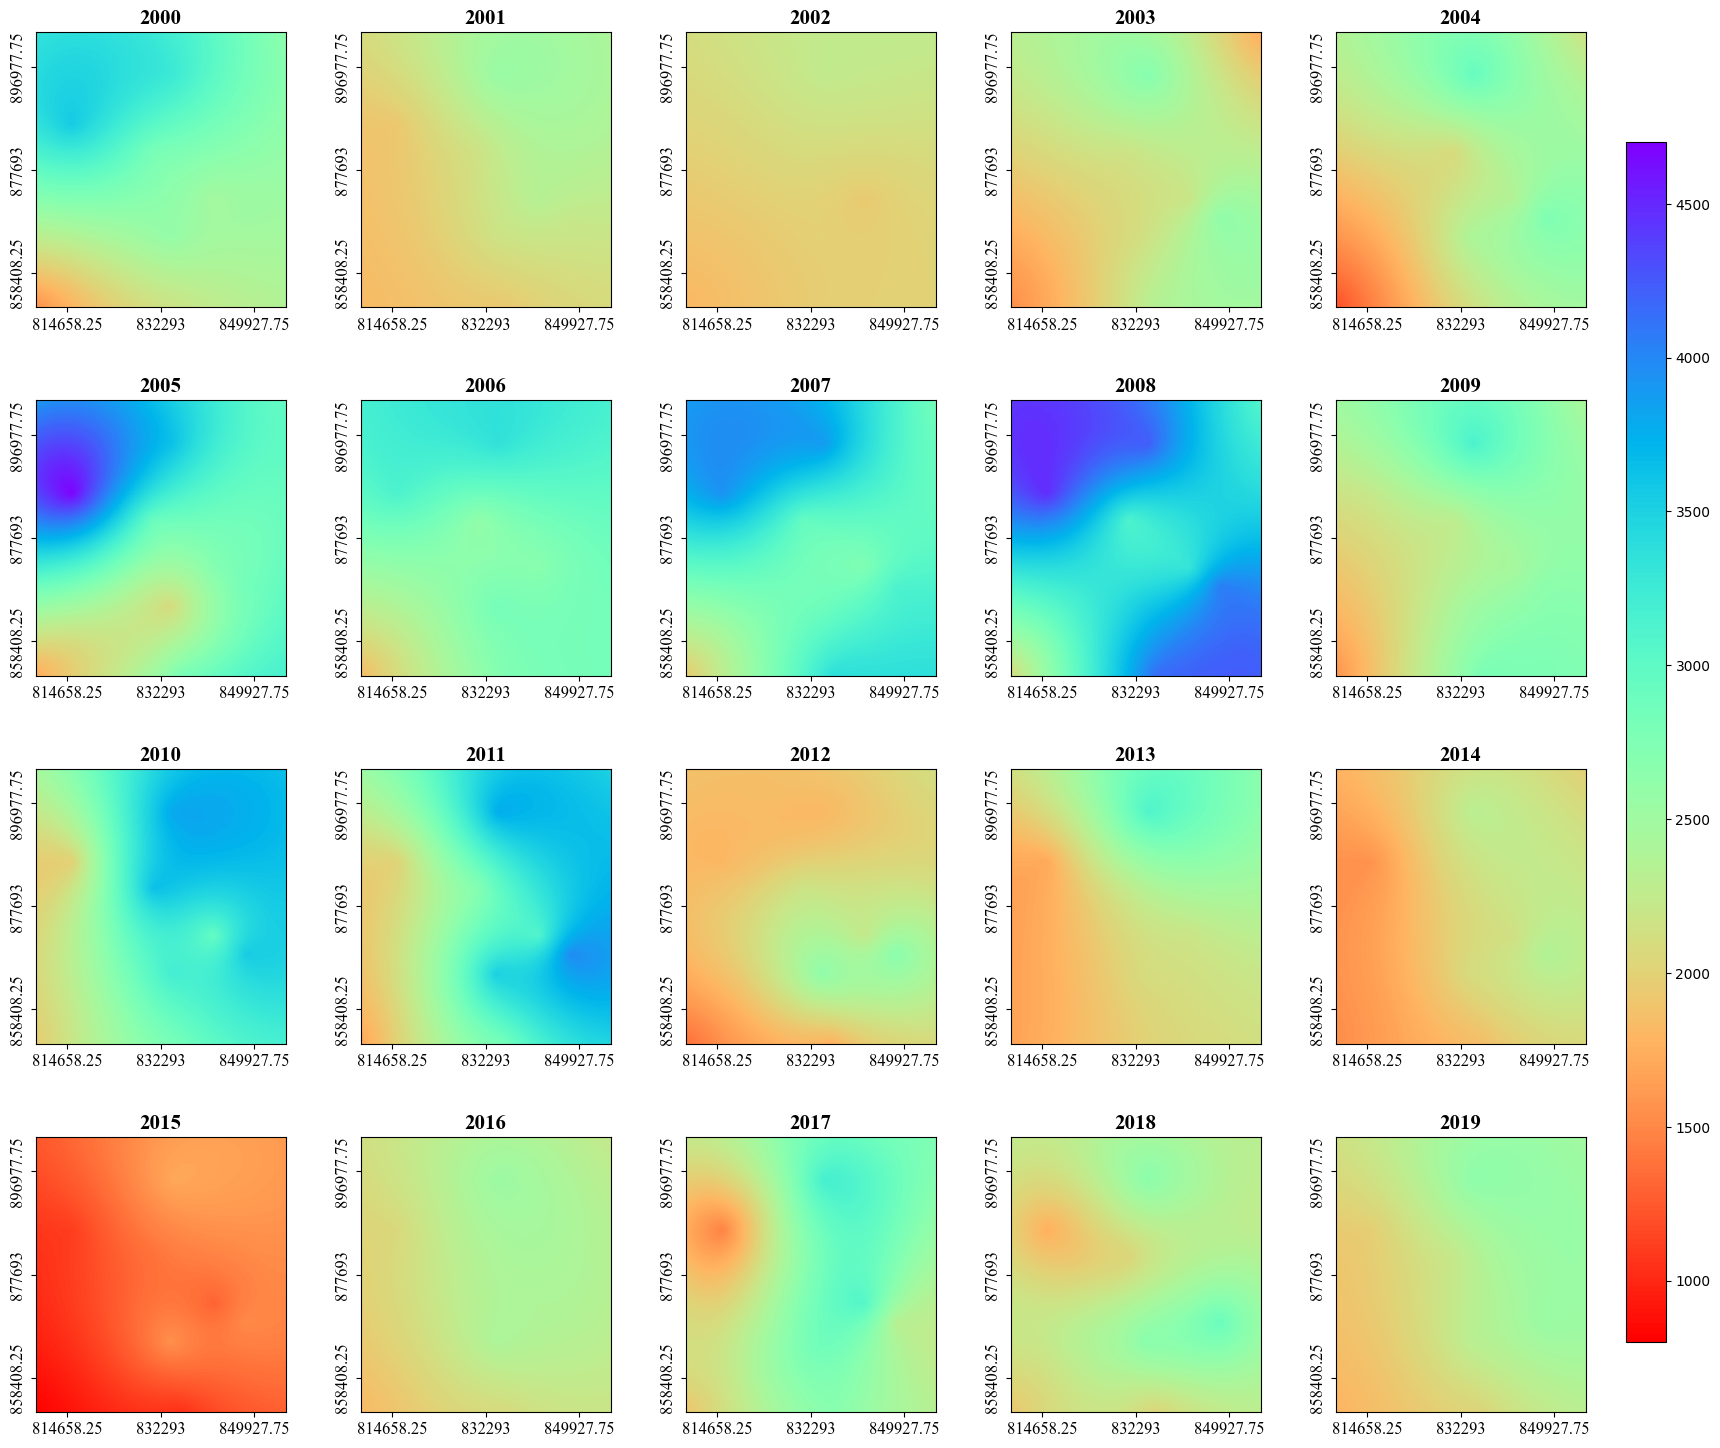

In [107]:
## Hallando límites
transform = anoCopia[0].transform
# Obtener los límites geoespaciales
limites = rio.transform.array_bounds(anoCopia[0].shape[0], anoCopia[0].shape[1], transform)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 40))

for i in range(len(anoCopia)):  # Usando min() para evitar el IndexError
    ax = axes[i // 5, i % 5]
    
    ax.set_title(ano[i][-4:], fontname='Times New Roman', fontsize=15, fontweight='bold')
    imagen_plot = ax.imshow(anoCopia1[i], cmap='rainbow_r')

    vmin = 800  # Reemplaza con el valor mínimo que desees
    vmax = 4700  # Reemplaza con el valor máximo que desees
    imagen_plot.set_clim(vmin, vmax)

    x_V1 = 0
    x_V6 = 431
    x_VM = (x_V1+x_V6)/2
    x_VMMI = (x_V1+x_VM)/2
    x_VMMD = (x_V6+x_VM)/2
    x_VMMMI = (x_V1+x_VMMI)/2
    x_VMMMD = (x_V6+x_VMMD)/2

    x_N1 = int(limites[0])
    x_N6 = int(limites[1])
    x_NM = (x_N1+x_N6)/2
    x_NMMI = (x_N1+x_NM)/2
    x_NMMD = (x_N6+x_NM)/2
    x_NMMMI = (x_N1+x_NMMI)/2
    x_NMMMD = (x_N6+x_NMMD)/2
    
    x_viejo = [x_VMMMI,x_VM,x_VMMMD]
    x_nuevo = [x_NMMMI,int(x_NM),x_NMMMD]
    
    ax.set_xticks(x_viejo)
    ax.set_xticklabels(x_nuevo)
###################################################    
    y_VT = 0
    y_VB = 475
    y_VM = (y_VT+y_VB)/2
    y_VMMT = (y_VT+y_VM)/2
    y_VMMB = (y_VB+y_VM)/2
    y_VMMMT = (y_VT+y_VMMT)/2
    y_VMMMB = (y_VB+y_VMMB)/2
    
    y_NT = int(limites[2])
    y_NB = int(limites[3])
    y_NM = (y_NT+y_NB)/2
    y_NMMT = (y_NT+y_NM)/2
    y_NMMB = (y_NB+y_NM)/2
    y_NMMMT = (y_NT+y_NMMT)/2
    y_NMMMB = (y_NB+y_NMMB)/2

    y_viejo = [y_VMMMB,y_VM,y_VMMMT]
    y_nuevo = [y_NMMMT,int(y_NM),y_NMMMB]
    
    ax.set_yticks(y_viejo)
    ax.set_yticklabels(y_nuevo)

    ax.tick_params(axis='y', rotation = 90)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_verticalalignment('center')  # O 'center' según tus necesidades

    ax.set_xticklabels(ax.get_xticklabels(), fontname='Times New Roman', fontsize = 12)
    ax.set_yticklabels(ax.get_yticklabels(), fontname='Times New Roman', fontsize = 12)

    
cbar_ax = fig.add_axes([0.92, 0.4, 0.02, 0.3])  # Ajusta los valores según tu diseño
cbar = fig.colorbar(imagen_plot, cax=cbar_ax)
plt.subplots_adjust(top=1, hspace=-0.85, wspace=0.3)
#plt.savefig('FINAL_AñosPromediosInterpolaciones.png', dpi=500, bbox_inches='tight')


## Graficando promedios interpolaciones Mensuales

In [24]:
mesesPromAux = mes.copy()
mesesPromAux1 = [[],[],[],[],[],[],[],[],[],[],[],[]]
mesesProm = [[],[],[],[],[],[],[],[],[],[],[],[]]

for i in range(len(mesCopia)):
    mesesPromAux[i] = mesCopia1[i]
contador = 0
for i in range(len(mesesPromAux)):
    #elementos[contador].append(valor)  ## Verificador
    mesesPromAux1 [contador].append(mesesPromAux[i])
    contador += 1
    
    if (i+1) % 12 == 0:
        contador = 0
for i in range(len(mesesProm)):
    mesesProm[i] = np.mean(mesesPromAux1[i], axis=0)

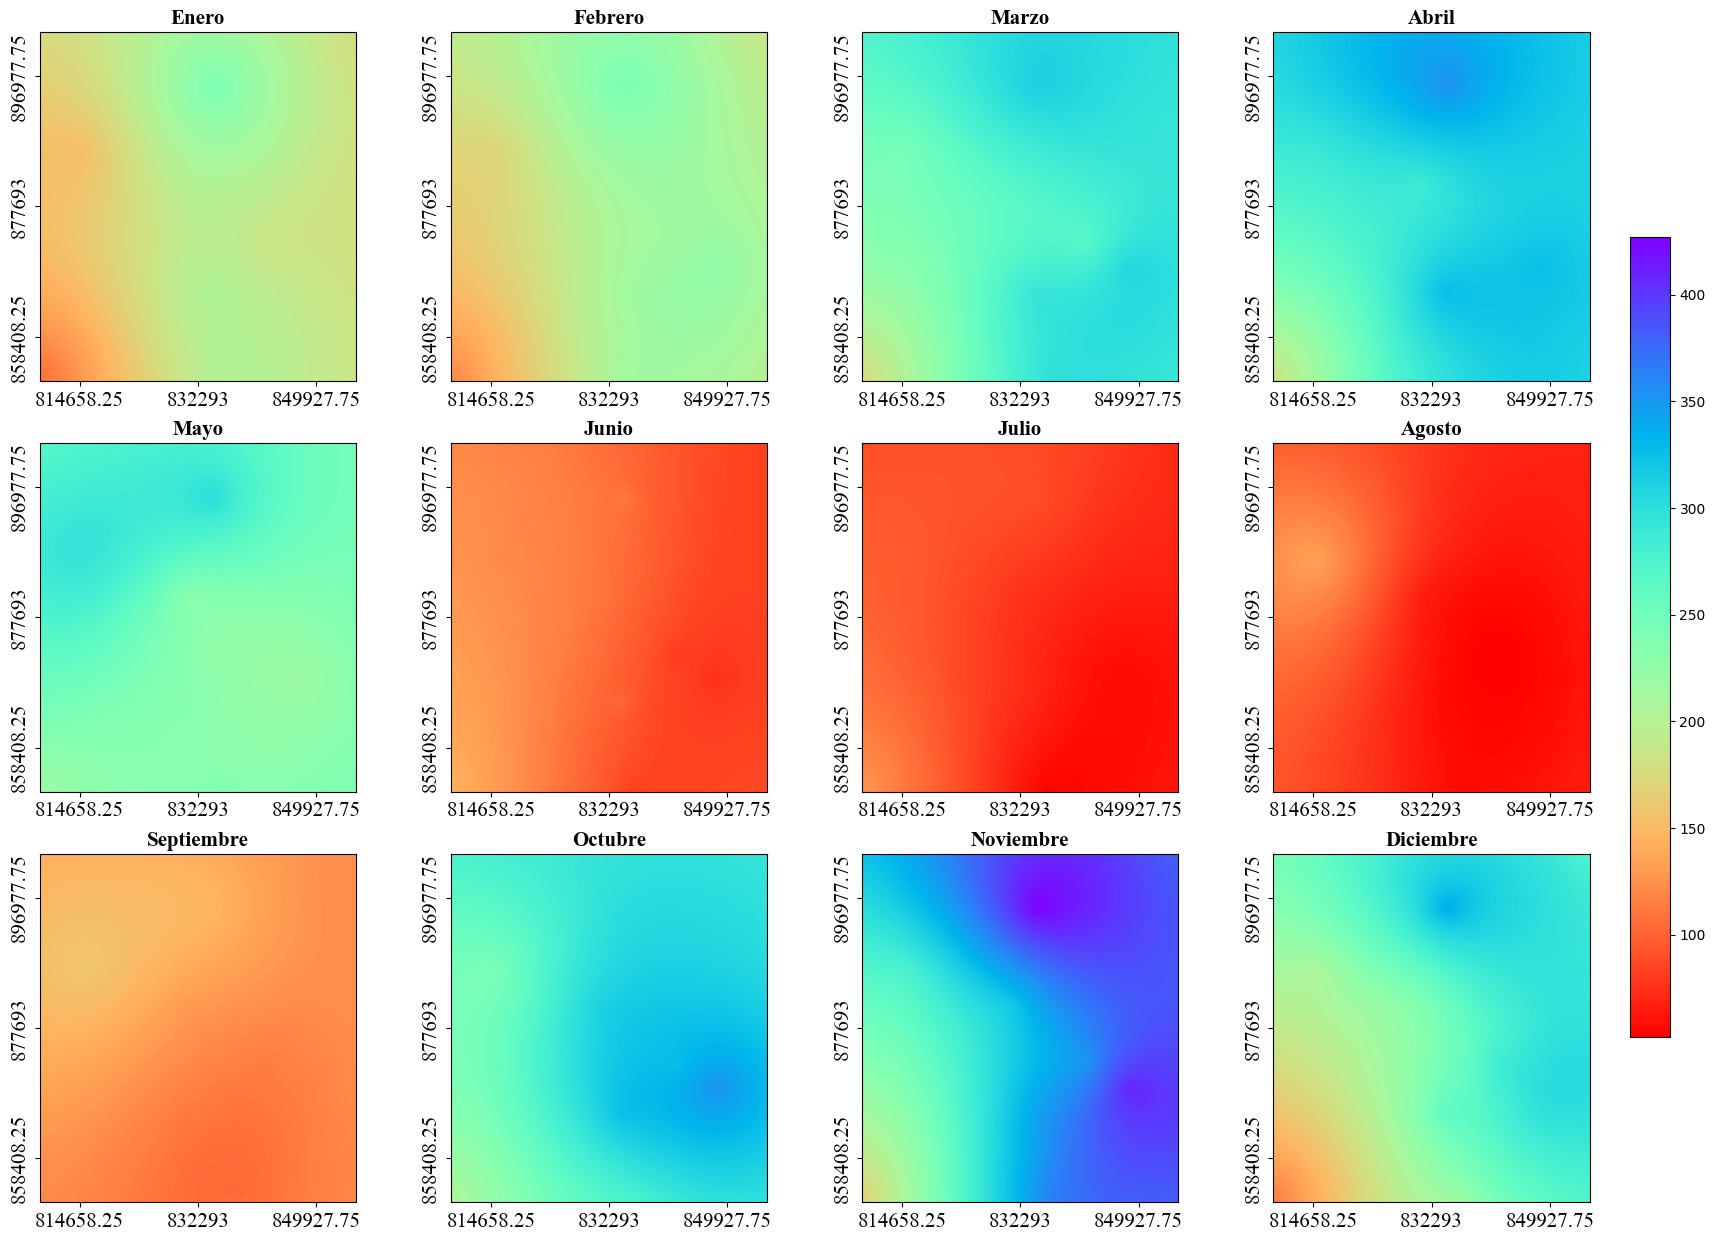

In [37]:
## Hallando límites
transform = mesCopia[0].transform
# Obtener los límites geoespaciales
limites = rio.transform.array_bounds(mesCopia[0].shape[0], mesCopia[0].shape[1], transform)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 40))

for i in range(len(mesesProm)):
    ax = axes[i // 4, i % 4]

    ax.set_title(meses[i], fontname='Times New Roman', fontsize=15, fontweight='bold')
    imagen_plot = ax.imshow(mesesProm[i], cmap='rainbow_r')

    vmax = 0
    vmin = 2000
    for i in range(len(mesesProm)):
        max_value = mesesProm[i].max()
        min_value = mesesProm[i].min()
        
        if max_value > vmax:
            vmax = max_value
        if min_value < vmin:
            vmin = min_value
            
    imagen_plot.set_clim(vmin, vmax)

    x_V1 = 0
    x_V6 = 431
    x_VM = (x_V1+x_V6)/2
    x_VMMI = (x_V1+x_VM)/2
    x_VMMD = (x_V6+x_VM)/2
    x_VMMMI = (x_V1+x_VMMI)/2
    x_VMMMD = (x_V6+x_VMMD)/2

    x_N1 = int(limites[0])
    x_N6 = int(limites[1])
    x_NM = (x_N1+x_N6)/2
    x_NMMI = (x_N1+x_NM)/2
    x_NMMD = (x_N6+x_NM)/2
    x_NMMMI = (x_N1+x_NMMI)/2
    x_NMMMD = (x_N6+x_NMMD)/2
    
    x_viejo = [x_VMMMI,x_VM,x_VMMMD]
    x_nuevo = [x_NMMMI,int(x_NM),x_NMMMD]
    
    ax.set_xticks(x_viejo)
    ax.set_xticklabels(x_nuevo)
###################################################    
    y_VT = 0
    y_VB = 475
    y_VM = (y_VT+y_VB)/2
    y_VMMT = (y_VT+y_VM)/2
    y_VMMB = (y_VB+y_VM)/2
    y_VMMMT = (y_VT+y_VMMT)/2
    y_VMMMB = (y_VB+y_VMMB)/2
    
    y_NT = int(limites[2])
    y_NB = int(limites[3])
    y_NM = (y_NT+y_NB)/2
    y_NMMT = (y_NT+y_NM)/2
    y_NMMB = (y_NB+y_NM)/2
    y_NMMMT = (y_NT+y_NMMT)/2
    y_NMMMB = (y_NB+y_NMMB)/2

    y_viejo = [y_VMMMB,y_VM,y_VMMMT]
    y_nuevo = [y_NMMMT,int(y_NM),y_NMMMB]
    
    ax.set_yticks(y_viejo)
    ax.set_yticklabels(y_nuevo)
    
    ax.tick_params(axis='y', rotation = 90)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_verticalalignment('center')  # O 'center' según tus necesidades

    ax.set_xticklabels(ax.get_xticklabels(), fontname='Times New Roman', fontsize = 15)
    ax.set_yticklabels(ax.get_yticklabels(), fontname='Times New Roman', fontsize = 15)


cbar_ax = fig.add_axes([0.92, 0.45, 0.02, 0.2])  # Ajusta los valores según tu diseño
cbar = fig.colorbar(imagen_plot, cax=cbar_ax)
plt.subplots_adjust(top=1, hspace=-0.85, wspace=0.3)
#######g-----

## Meses Invierno - Verano

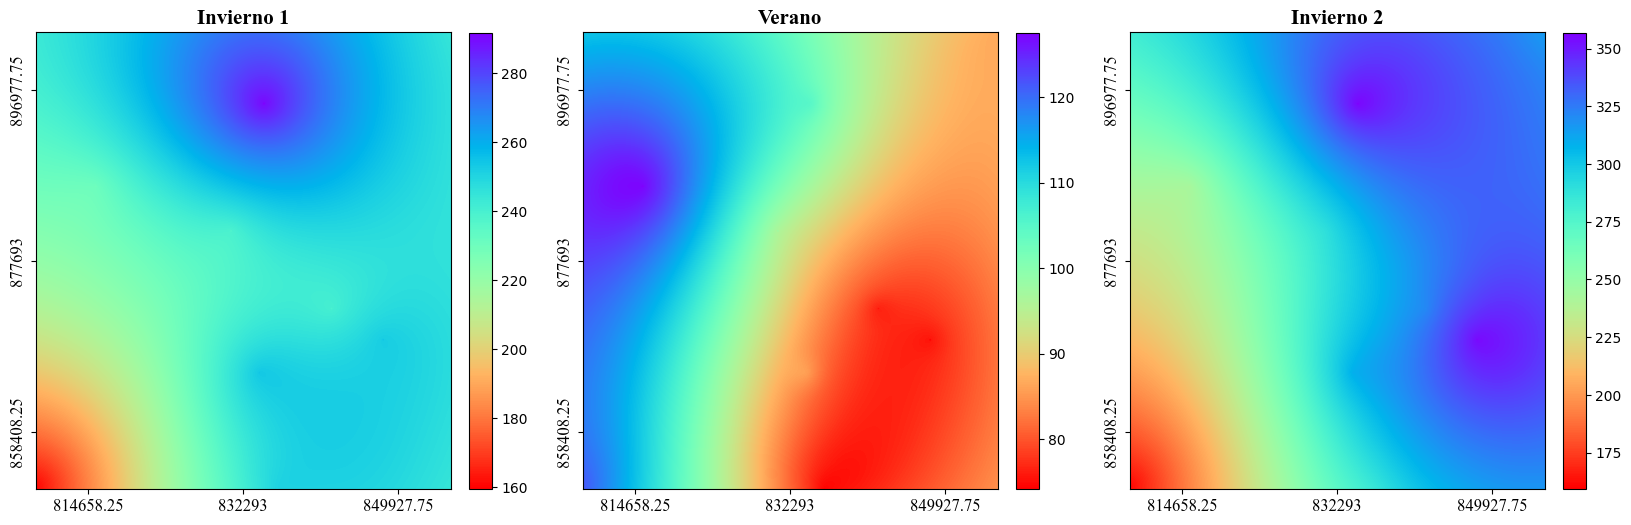

In [108]:
estacionesNombres = ['Invierno 1', 'Verano', 'Invierno 2']
estaciones = ['invierno1', 'verano', 'invierno2']
for i in range(len(estaciones)):
    if i == 0:
        estaciones[i] = (mesesProm[0] + mesesProm[1] + mesesProm[2] + mesesProm[3] + mesesProm[4])/5
    elif i == 1:
        estaciones[i] = (mesesProm[5] + mesesProm[6] + mesesProm[7] + mesesProm[8])/4
    elif i == 2:
        estaciones[i] = (mesesProm[9] + mesesProm[10] + mesesProm[11])/3

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 40))

for i in range(min(len(mesesProm), len(axes))):
    ax = axes[i]

    ax.set_title(estacionesNombres[i], fontname='Times New Roman', fontsize=15, fontweight='bold')
    imagen_plot = ax.imshow(estaciones[i], cmap='rainbow_r')
    color_bar = plt.colorbar(imagen_plot, ax=ax, fraction=0.05, pad=0.04)

    #if i == 0:
    #    imagen_plot.set_clim(155, 295)
    #elif i == 1:
    #    imagen_plot.set_clim(75, 125)

    x_V1 = 0
    x_V6 = 431
    x_VM = (x_V1+x_V6)/2
    x_VMMI = (x_V1+x_VM)/2
    x_VMMD = (x_V6+x_VM)/2
    x_VMMMI = (x_V1+x_VMMI)/2
    x_VMMMD = (x_V6+x_VMMD)/2

    x_N1 = int(limites[0])
    x_N6 = int(limites[1])
    x_NM = (x_N1+x_N6)/2
    x_NMMI = (x_N1+x_NM)/2
    x_NMMD = (x_N6+x_NM)/2
    x_NMMMI = (x_N1+x_NMMI)/2
    x_NMMMD = (x_N6+x_NMMD)/2
    
    x_viejo = [x_VMMMI,x_VM,x_VMMMD]
    x_nuevo = [x_NMMMI,int(x_NM),x_NMMMD]
    
    ax.set_xticks(x_viejo)
    ax.set_xticklabels(x_nuevo)
###################################################    
    y_VT = 0
    y_VB = 475
    y_VM = (y_VT+y_VB)/2
    y_VMMT = (y_VT+y_VM)/2
    y_VMMB = (y_VB+y_VM)/2
    y_VMMMT = (y_VT+y_VMMT)/2
    y_VMMMB = (y_VB+y_VMMB)/2
    
    y_NT = int(limites[2])
    y_NB = int(limites[3])
    y_NM = (y_NT+y_NB)/2
    y_NMMT = (y_NT+y_NM)/2
    y_NMMB = (y_NB+y_NM)/2
    y_NMMMT = (y_NT+y_NMMT)/2
    y_NMMMB = (y_NB+y_NMMB)/2

    y_viejo = [y_VMMMB,y_VM,y_VMMMT]
    y_nuevo = [y_NMMMT,int(y_NM),y_NMMMB]
    
    ax.set_yticks(y_viejo)
    ax.set_yticklabels(y_nuevo)
    
    ax.tick_params(axis='y', rotation = 90)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_verticalalignment('center')  # O 'center' según tus necesidades

    ax.set_xticklabels(ax.get_xticklabels(), fontname='Times New Roman', fontsize = 12)
    ax.set_yticklabels(ax.get_yticklabels(), fontname='Times New Roman', fontsize = 12)
    
    #vmin = 74.19348  # Reemplaza con el valor mínimo que desees
    #vmax = 356.8492  # Reemplaza con el valor máximo que desees
    #imagen_plot.set_clim(vmin, vmax)
#plt.savefig('FINAL_PromediosTotalesEstaciones.png', dpi=500, bbox_inches='tight')

In [321]:
for i in range(3):
    print(f'---{i}---')
    print(f'Max: {estaciones[i].max()}')
    print(f'Min: {estaciones[i].min()}')

---0---
Max: 291.7958984375
Min: 159.53402709960938
---1---
Max: 127.52008056640625
Min: 74.1934814453125
---2---
Max: 356.8492126464844
Min: 159.35865783691406


## Años clasificación

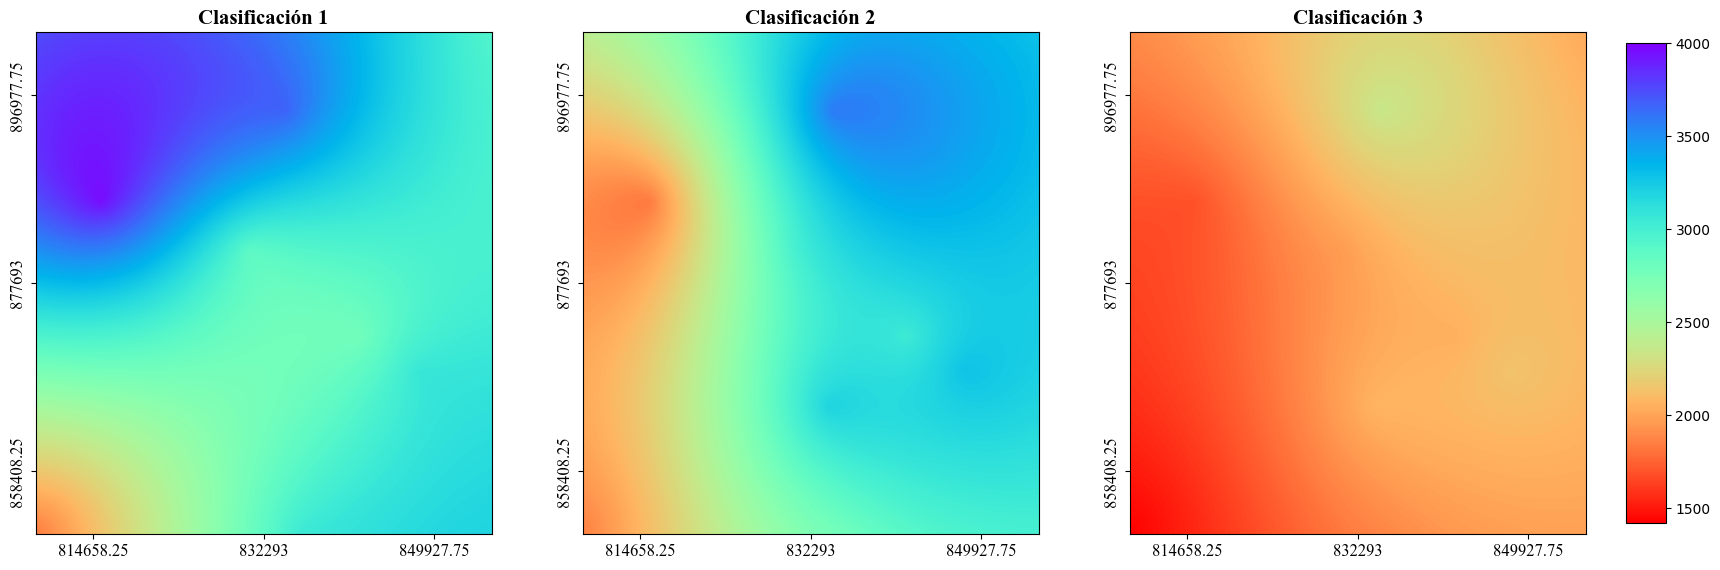

In [109]:
estacionesNombres = ['Clasificación 1', 'Clasificación 2', 'Clasificación 3']
estaciones = ['lluvia', 'intermedio', 'seco']
for i in range(len(estaciones)):
    if i == 0:
        estaciones[i] = (anoCopia1[0] + anoCopia1[5] + anoCopia1[6] + anoCopia1[7] + anoCopia1[8])/5
    elif i == 1:
        estaciones[i] = (anoCopia1[10] + anoCopia1[11] + anoCopia1[17])/3
    elif i == 2:
        estaciones[i] = (anoCopia1[1] + anoCopia1[2] + anoCopia1[3] + anoCopia1[4] + anoCopia1[9] + anoCopia1[12] + anoCopia1[13] + anoCopia1[14] +
                        anoCopia1[15] + anoCopia1[16] + anoCopia1[17])/12

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 40))

for i in range(min(len(estaciones), len(axes))):
    ax = axes[i]

    ax.set_title(estacionesNombres[i], fontname='Times New Roman', fontsize=15, fontweight='bold')
    imagen_plot = ax.imshow(estaciones[i], cmap='rainbow_r')
    #color_bar = plt.colorbar(imagen_plot, ax=ax, fraction=0.05, pad=0.04)

    vmin = 1420  # Reemplaza con el valor mínimo que desees
    vmax = 4000  # Reemplaza con el valor máximo que desees
    imagen_plot.set_clim(vmin, vmax)

    x_V1 = 0
    x_V6 = 431
    x_VM = (x_V1+x_V6)/2
    x_VMMI = (x_V1+x_VM)/2
    x_VMMD = (x_V6+x_VM)/2
    x_VMMMI = (x_V1+x_VMMI)/2
    x_VMMMD = (x_V6+x_VMMD)/2

    x_N1 = int(limites[0])
    x_N6 = int(limites[1])
    x_NM = (x_N1+x_N6)/2
    x_NMMI = (x_N1+x_NM)/2
    x_NMMD = (x_N6+x_NM)/2
    x_NMMMI = (x_N1+x_NMMI)/2
    x_NMMMD = (x_N6+x_NMMD)/2
    
    x_viejo = [x_VMMMI,x_VM,x_VMMMD]
    x_nuevo = [x_NMMMI,int(x_NM),x_NMMMD]
    
    ax.set_xticks(x_viejo)
    ax.set_xticklabels(x_nuevo)
###################################################    
    y_VT = 0
    y_VB = 475
    y_VM = (y_VT+y_VB)/2
    y_VMMT = (y_VT+y_VM)/2
    y_VMMB = (y_VB+y_VM)/2
    y_VMMMT = (y_VT+y_VMMT)/2
    y_VMMMB = (y_VB+y_VMMB)/2
    
    y_NT = int(limites[2])
    y_NB = int(limites[3])
    y_NM = (y_NT+y_NB)/2
    y_NMMT = (y_NT+y_NM)/2
    y_NMMB = (y_NB+y_NM)/2
    y_NMMMT = (y_NT+y_NMMT)/2
    y_NMMMB = (y_NB+y_NMMB)/2

    y_viejo = [y_VMMMB,y_VM,y_VMMMT]
    y_nuevo = [y_NMMMT,int(y_NM),y_NMMMB]
    
    ax.set_yticks(y_viejo)
    ax.set_yticklabels(y_nuevo)
    
    ax.tick_params(axis='y', rotation = 90)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_verticalalignment('center')  # O 'center' según tus necesidades

    ax.set_xticklabels(ax.get_xticklabels(), fontname='Times New Roman', fontsize = 12)
    ax.set_yticklabels(ax.get_yticklabels(), fontname='Times New Roman', fontsize = 12)

    #if i == 2:
        #imagen_plot.set_clim(1425, 2350)
    #else:
        #imagen_plot.set_clim(1830, 3960)

cbar_ax = fig.add_axes([0.92, 0.435, 0.02, 0.12])  # Ajusta los valores según tu diseño
cbar = fig.colorbar(imagen_plot, cax=cbar_ax)

#plt.savefig('FINAL_PromediosTotalesClasificacion.png', dpi=500, bbox_inches='tight')

In [53]:
for i in range(3):
    print(f'---{i}---')
    print(f'Max: {estaciones[i].max()}')
    print(f'Min: {estaciones[i].min()}')

---0---
Max: 3949.403076171875
Min: 1849.561279296875
---1---
Max: 3576.281982421875
Min: 1832.7830810546875
---2---
Max: 2347.442626953125
Min: 1428.2611083984375


## Cruces

In [54]:
ano = []
mes = []
factorR = []

for i in range(20):
    if i < 10:
        ano.append('PAnual200{}'.format(i))
    else:
        ano.append('PAnual20{}'.format(i))
        
    for j in range(12):
        if j < 9:
            if i < 10:
                mes.append('PMes200{}_0{}'.format(i,j+1))
                factorR.append('FRMes200{}_0{}'.format(i,j+1))
            else:
                mes.append('PMes20{}_0{}'.format(i,j+1))
                factorR.append('FRMes20{}_0{}'.format(i,j+1))
        else:
            if i < 10:
                mes.append('PMes200{}_{}'.format(i,j+1))
                factorR.append('FRMes200{}_{}'.format(i,j+1))
            else:
                mes.append('PMes20{}_{}'.format(i,j+1))
                factorR.append('FRMes20{}_{}'.format(i,j+1))

FactorR_meses = []
meses = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']

for j in range(12):
    FactorR_meses.append(f'FR_{meses[j]}')

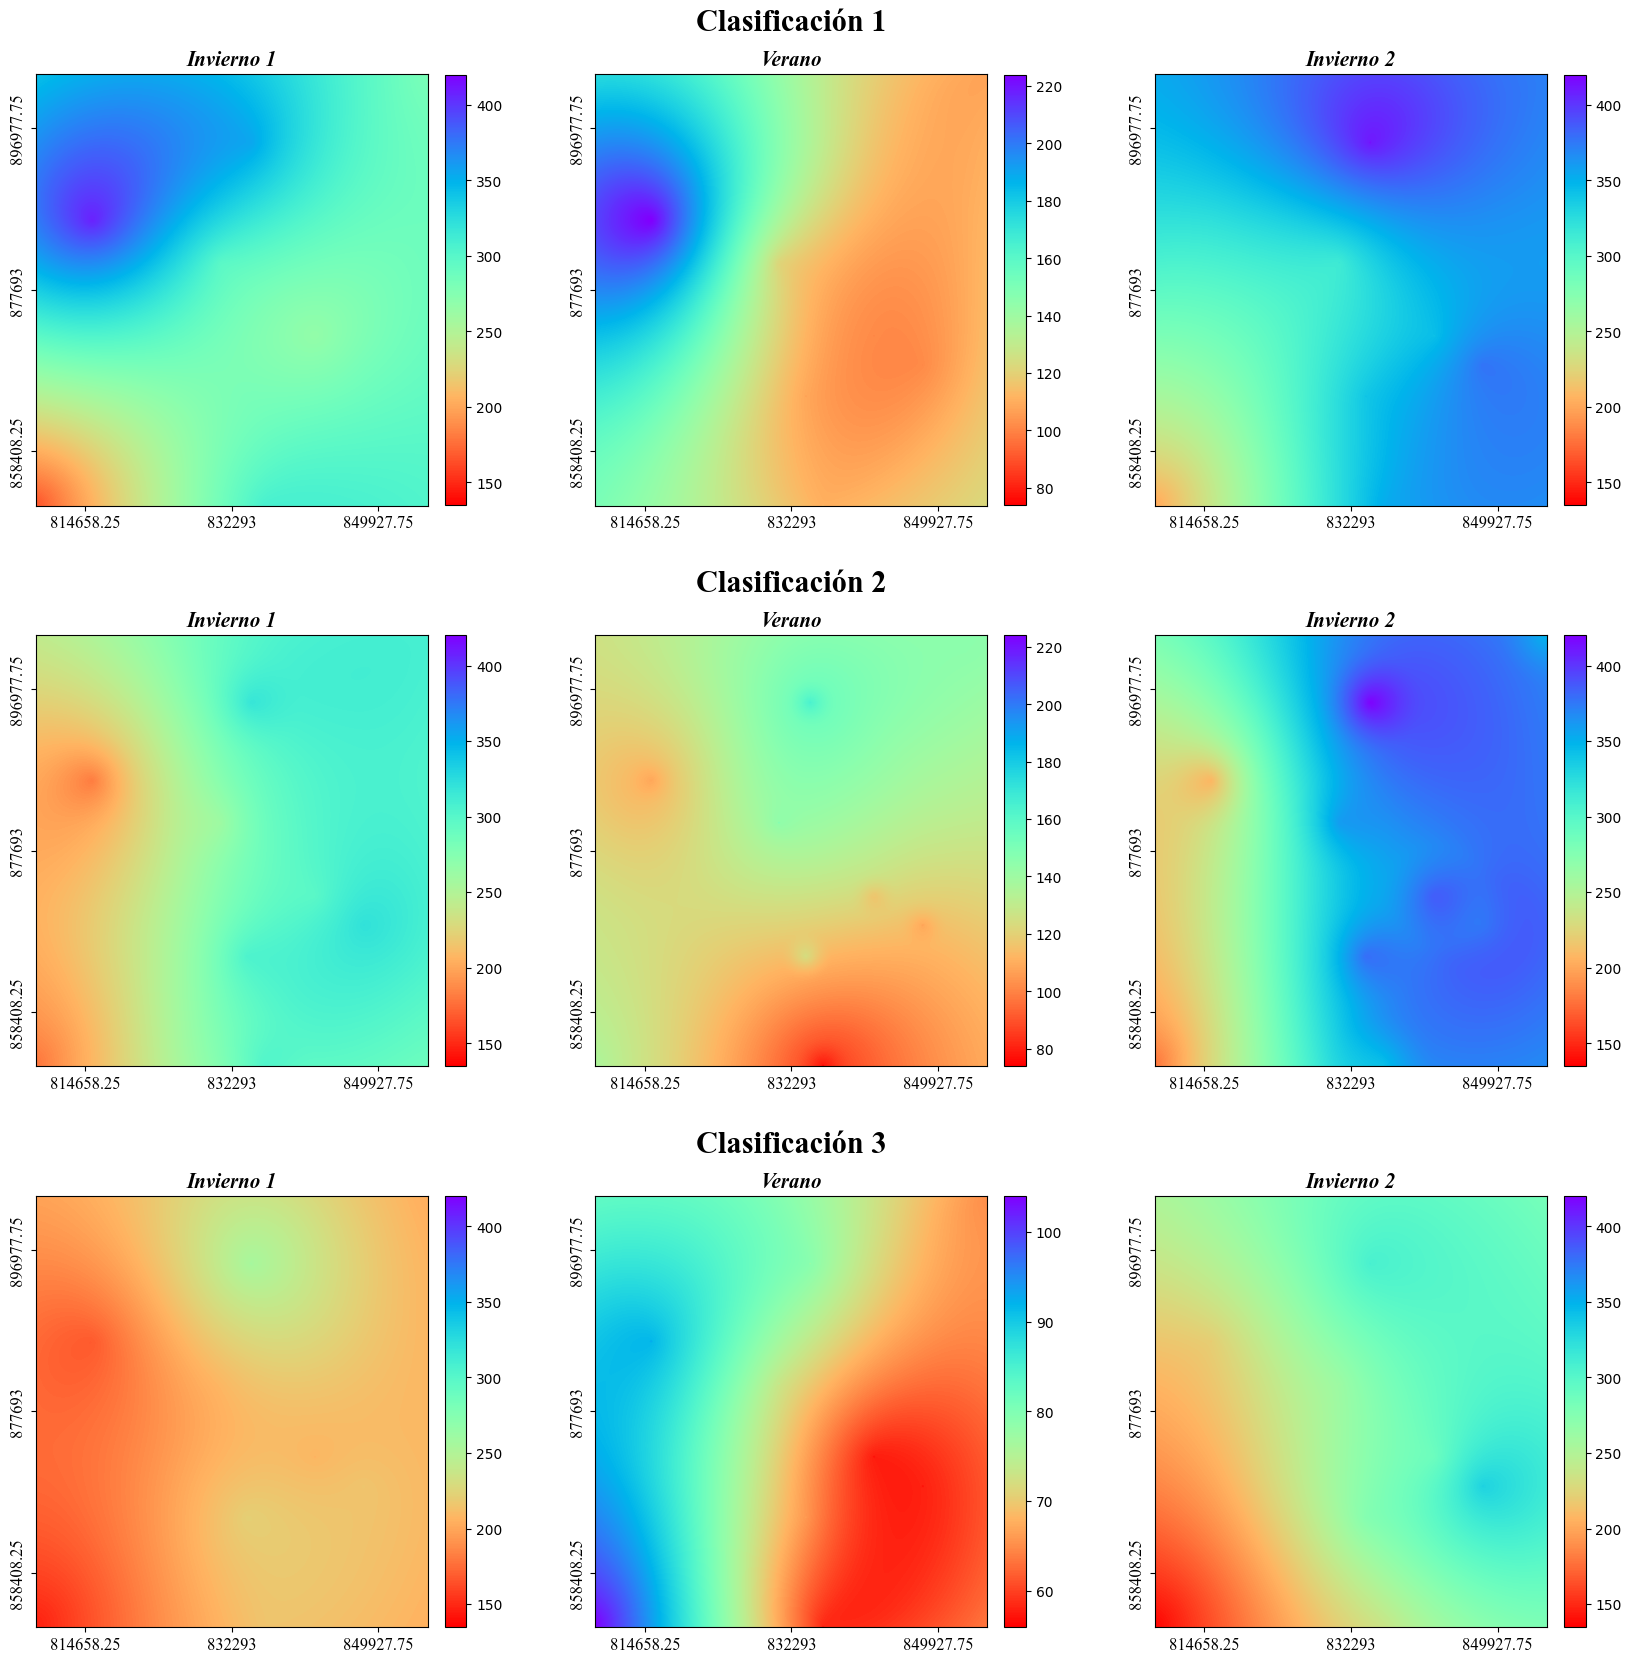

In [110]:
indicadorAnual = [[0,5,6,7,8],[10,11,17],[1,2,3,4,9,12,13,14,15,16,17]]
indicadorAnualAux = [ [[],[],[]]   ,[[],[],[]],  [[],[],[]] ]
indicadorMensual = [[0,1,2,3,4],[5,6,7,8],[9,10,11]]
promTemporadas = [ ['invierno1', 'verano', 'invierno2']   ,['invierno1', 'verano', 'invierno2'],  ['invierno1', 'verano', 'invierno2'] ]

for i in range(19):
    if i in indicadorAnual[0]:
        #print(ano[i][-4:])
        
        for j in range(12):
            if j in indicadorMensual[0]:
                #print(f'PMes{ano[i][-4:]}_0{j+1}')
                indice = mes.index(f'PMes{ano[i][-4:]}_0{j+1}')
                indicadorAnualAux[0][0].append(mesCopia1[indice])
                    
            elif j in indicadorMensual[1]:
                #print(f'PMes{ano[i][-4:]}_0{j+1}')
                indice = mes.index(f'PMes{ano[i][-4:]}_0{j+1}')
                indicadorAnualAux[0][1].append(mesCopia1[indice])
            
            elif j in indicadorMensual[2]:
                if j+1 < 10:
                    #print(f'PMes{ano[i][-4:]}_0{j+1}')
                    indice = mes.index(f'PMes{ano[i][-4:]}_0{j+1}')
                    indicadorAnualAux[0][2].append(mesCopia1[indice])
                else:
                    #print(f'PMes{ano[i][-4:]}_{j+1}')
                    indice = mes.index(f'PMes{ano[i][-4:]}_{j+1}')
                    indicadorAnualAux[0][2].append(mesCopia1[indice])

    elif i in indicadorAnual[1]:

        for j in range(12):
            if j in indicadorMensual[0]:
                #print(f'PMes{ano[i][-4:]}_0{j+1}')
                indice = mes.index(f'PMes{ano[i][-4:]}_0{j+1}')
                indicadorAnualAux[1][0].append(mesCopia1[indice])
                    
            elif j in indicadorMensual[1]:
                #print(f'PMes{ano[i][-4:]}_0{j+1}')
                indice = mes.index(f'PMes{ano[i][-4:]}_0{j+1}')
                indicadorAnualAux[1][1].append(mesCopia1[indice])
            
            elif j in indicadorMensual[2]:
                if j+1 < 10:
                    #print(f'PMes{ano[i][-4:]}_0{j+1}')
                    indice = mes.index(f'PMes{ano[i][-4:]}_0{j+1}')
                    indicadorAnualAux[1][2].append(mesCopia1[indice])
                else:
                    #print(f'PMes{ano[i][-4:]}_{j+1}')
                    indice = mes.index(f'PMes{ano[i][-4:]}_{j+1}')
                    indicadorAnualAux[1][2].append(mesCopia1[indice])

    elif i in indicadorAnual[2]:

        for j in range(12):
            if j in indicadorMensual[0]:
                #print(f'PMes{ano[i][-4:]}_0{j+1}')
                indice = mes.index(f'PMes{ano[i][-4:]}_0{j+1}')
                indicadorAnualAux[2][0].append(mesCopia1[indice])
                    
            elif j in indicadorMensual[1]:
                #print(f'PMes{ano[i][-4:]}_0{j+1}')
                indice = mes.index(f'PMes{ano[i][-4:]}_0{j+1}')
                indicadorAnualAux[2][1].append(mesCopia1[indice])
            
            elif j in indicadorMensual[2]:
                if j+1 < 10:
                    #print(f'PMes{ano[i][-4:]}_0{j+1}')
                    indice = mes.index(f'PMes{ano[i][-4:]}_0{j+1}')
                    indicadorAnualAux[2][2].append(mesCopia1[indice])
                else:
                    #print(f'PMes{ano[i][-4:]}_{j+1}')
                    indice = mes.index(f'PMes{ano[i][-4:]}_{j+1}')
                    indicadorAnualAux[2][2].append(mesCopia1[indice])

for i in range(len(indicadorAnualAux)):
    for j in range(len(indicadorAnualAux[i])):
        promTemporadas[i][j] = np.mean(indicadorAnualAux[i][j], axis=0)

nombresCrucesPrec = ['Invierno 1', 'Verano', 'Invierno 2', 'Invierno 1', 'Verano', 'Invierno 2', 'Invierno 1', 'Verano', 'Invierno 2']
clasificaciones = ['Clasificación 1', 'Clasificación 2', 'Clasificación 3']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 40))

contadori = 0
contadorj = 0

for i in range(9):
    ax = axes[i // 3, i % 3]
    #ax.set_title(f'{[contadori]}{[contadorj]}', fontname='Times New Roman', fontsize=15, fontweight='bold')
    ax.set_title(nombresCrucesPrec[i], fontname='Times New Roman', fontsize=15, fontweight='bold', style='italic')

    imagen_plot = ax.imshow(promTemporadas[contadori][contadorj], cmap='rainbow_r')
    #cbar_ax = fig.add_axes([0.92, 0.4, 0.02, 0.3])  # Ajusta los valores según tu diseño
    color_bar = plt.colorbar(imagen_plot, ax=ax, fraction=0.05, pad=0.04)

        # Agregar títulos a cada fila
    if i % 3 == 1:
        ax.set_xlabel(clasificaciones[contadori], fontname='Times New Roman', fontsize=22, fontweight='bold')
        ax.xaxis.set_label_coords(0.5, 1.15)  # Ajustar según tus necesidades

    if contadorj == 1 and (contadori == 0 or contadori == 1):
        imagen_plot.set_clim(74, 224)
    elif contadorj == 1:
        imagen_plot.set_clim(56, 104)
        
    elif (contadorj == 0 or contadorj == 2):
        #and (contadori == 0 or contadori == 1)
        imagen_plot.set_clim(135, 420)
    
    contadorj += 1
    if contadorj == 3:
        contadorj = 0

    if i == 2 or i == 5:
        contadori += 1
        
    x_V1 = 0
    x_V6 = 431
    x_VM = (x_V1+x_V6)/2
    x_VMMI = (x_V1+x_VM)/2
    x_VMMD = (x_V6+x_VM)/2
    x_VMMMI = (x_V1+x_VMMI)/2
    x_VMMMD = (x_V6+x_VMMD)/2

    x_N1 = int(limites[0])
    x_N6 = int(limites[1])
    x_NM = (x_N1+x_N6)/2
    x_NMMI = (x_N1+x_NM)/2
    x_NMMD = (x_N6+x_NM)/2
    x_NMMMI = (x_N1+x_NMMI)/2
    x_NMMMD = (x_N6+x_NMMD)/2
    
    x_viejo = [x_VMMMI,x_VM,x_VMMMD]
    x_nuevo = [x_NMMMI,int(x_NM),x_NMMMD]
    
    ax.set_xticks(x_viejo)
    ax.set_xticklabels(x_nuevo)
###################################################    
    y_VT = 0
    y_VB = 475
    y_VM = (y_VT+y_VB)/2
    y_VMMT = (y_VT+y_VM)/2
    y_VMMB = (y_VB+y_VM)/2
    y_VMMMT = (y_VT+y_VMMT)/2
    y_VMMMB = (y_VB+y_VMMB)/2
    
    y_NT = int(limites[2])
    y_NB = int(limites[3])
    y_NM = (y_NT+y_NB)/2
    y_NMMT = (y_NT+y_NM)/2
    y_NMMB = (y_NB+y_NM)/2
    y_NMMMT = (y_NT+y_NMMT)/2
    y_NMMMB = (y_NB+y_NMMB)/2

    y_viejo = [y_VMMMB,y_VM,y_VMMMT]
    y_nuevo = [y_NMMMT,int(y_NM),y_NMMMB]
    
    ax.set_yticks(y_viejo)
    ax.set_yticklabels(y_nuevo)
    
    ax.tick_params(axis='y', rotation = 90)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_verticalalignment('center')  # O 'center' según tus necesidades

    ax.set_xticklabels(ax.get_xticklabels(), fontname='Times New Roman', fontsize = 12)
    ax.set_yticklabels(ax.get_yticklabels(), fontname='Times New Roman', fontsize = 12)

plt.subplots_adjust(top=1, hspace=-0.77, wspace=0.3)

#plt.savefig('FINAL_CrucesPrecipitaciones.png', dpi=500, bbox_inches='tight')

In [56]:
contadori = 0
contadorj = 0

for i in range(9):
    print(f'{[contadori]}---{[contadorj]}')
    print(f'Max: {promTemporadas[contadori][contadorj].max()}')
    print(f'Min: {promTemporadas[contadori][contadorj].min()}')
    
    contadorj += 1
    if contadorj == 3:
        contadorj = 0

    if i == 2 or i == 5:
        contadori += 1

[0]---[0]
Max: 406.8368835449219
Min: 166.2216033935547
[0]---[1]
Max: 224.14468383789062
Min: 98.60083770751953
[0]---[2]
Max: 414.6389465332031
Min: 197.18002319335938
[1]---[0]
Max: 322.4373779296875
Min: 178.09042358398438
[1]---[1]
Max: 164.5653839111328
Min: 74.23018646240234
[1]---[2]
Max: 418.327392578125
Min: 179.25286865234375
[2]---[0]
Max: 257.5760192871094
Min: 144.4187774658203
[2]---[1]
Max: 103.95091247558594
Min: 56.1813850402832
[2]---[2]
Max: 332.4247131347656
Min: 135.25433349609375


# Cruce Interpolaciones

## Calculando el factor R

### Mes a Mes

In [57]:
factorR_c = factorR.copy()
ctmes = 0
for i in range(20):
    for j in range(12):
        M = mesCopia1[ctmes]
        A = anoCopia1[i]
        factorR_c[ctmes] = (1.735 * 10**(1.5*np.log10(((M/25.4)**2)/A)-0.8188)*17.02)*10000
        ctmes += 1

### Promedio mensual de cada mes

In [58]:
FactorR_mesesCopia = FactorR_meses.copy()
contador = 0
elementos = [[],[],[],[],[],[],[],[],[],[],[],[]]

for i, valor in enumerate(factorR):
    #elementos[contador].append(valor)  ## Verificador
    elementos[contador].append(factorR_c[i])
    contador += 1
    
    if (i+1) % 12 == 0:
        contador = 0

for i in range(12):
    FactorR_mesesCopia[i] = np.mean(elementos[0], axis=0)

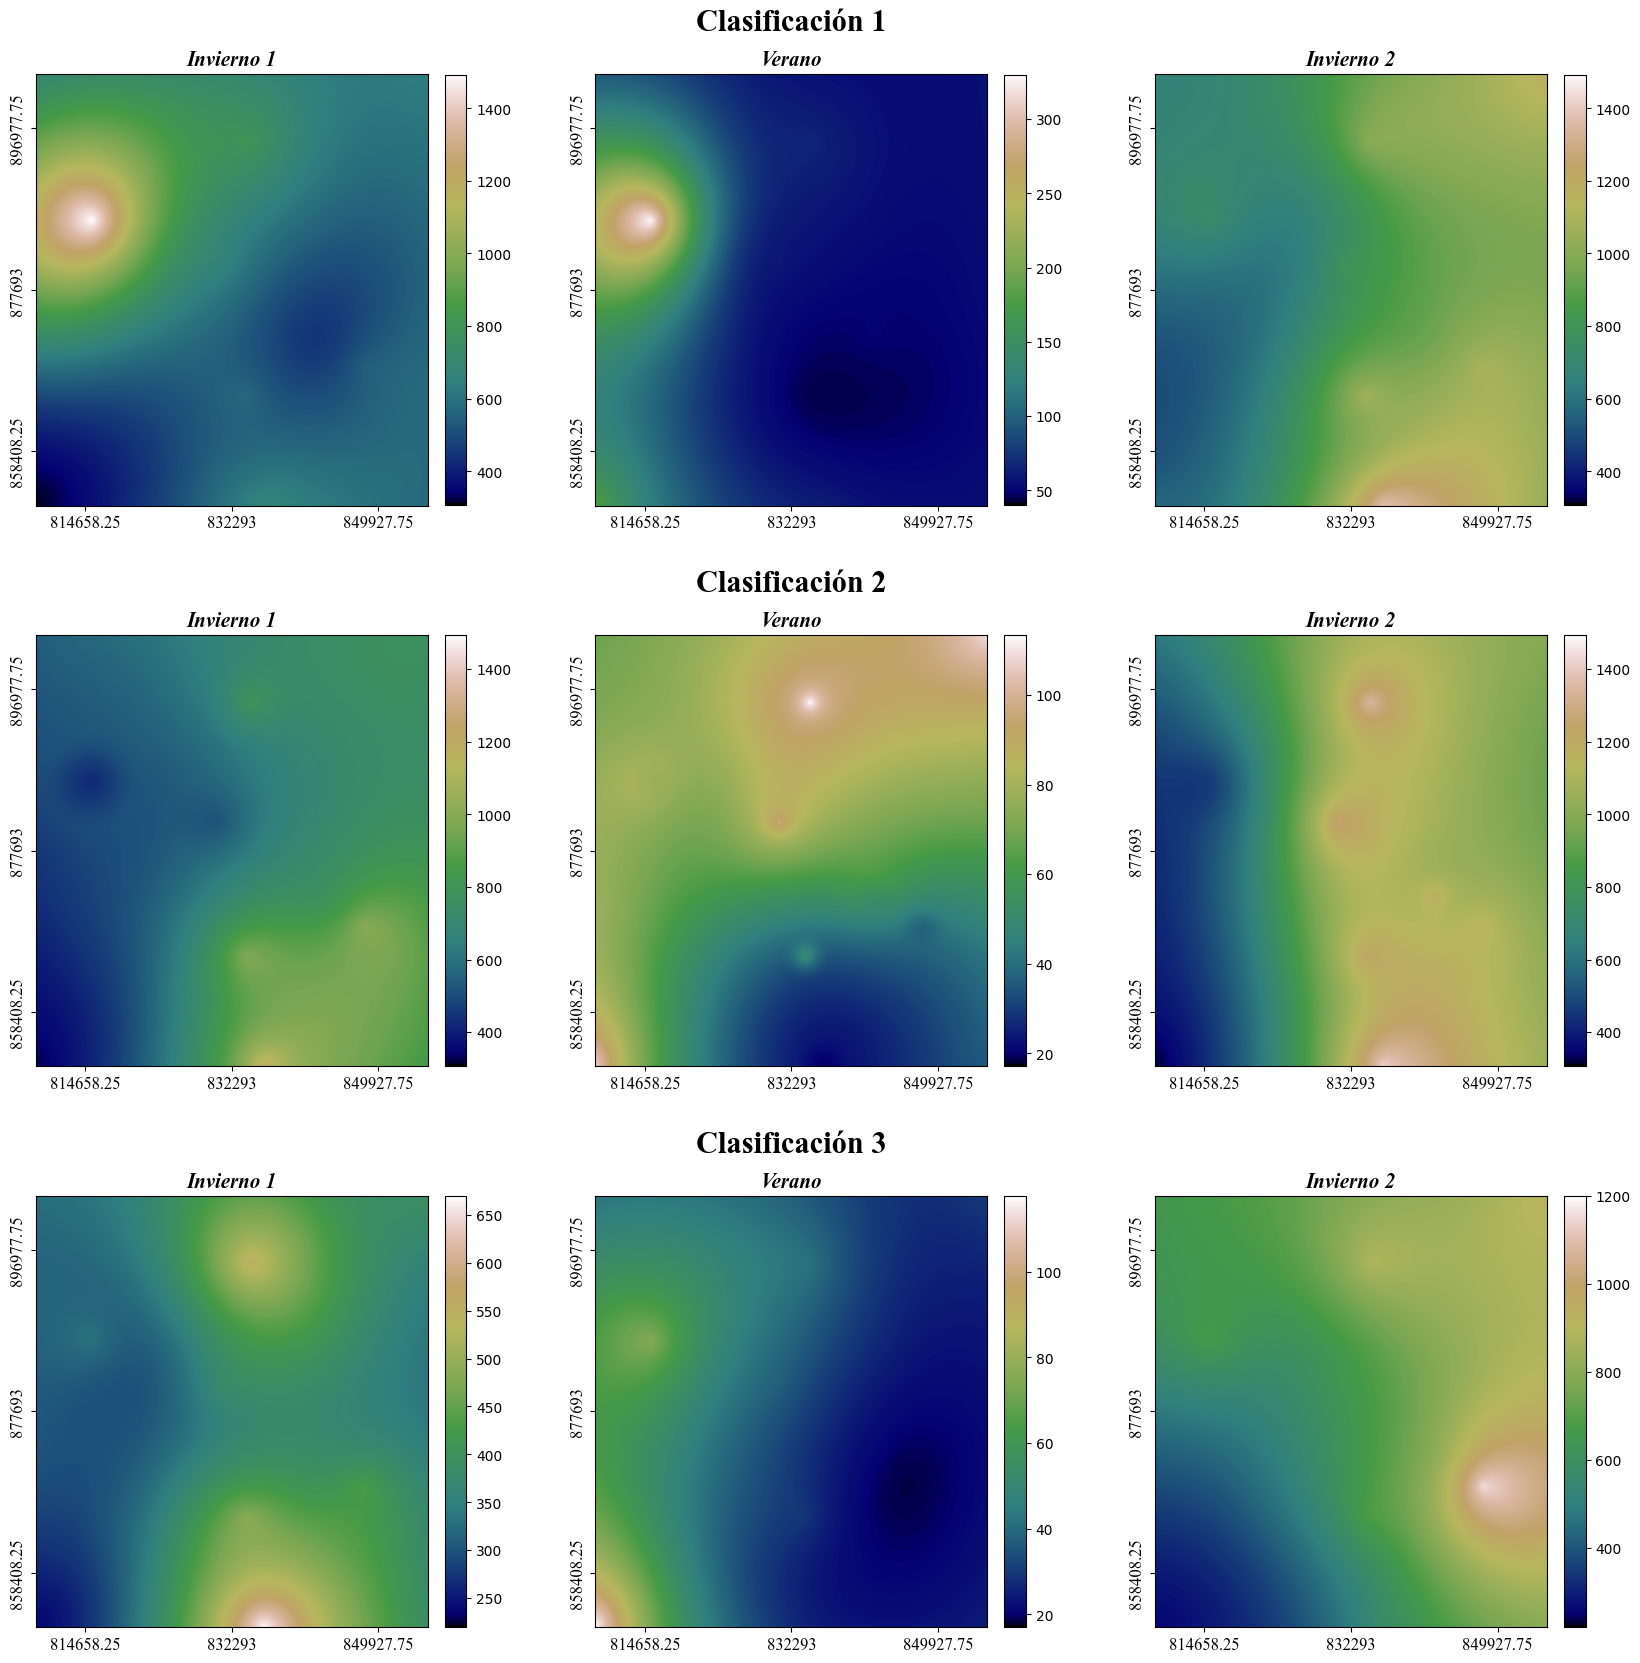

In [111]:
indicadorAnual = [[0,5,6,7,8],[10,11,17],[1,2,3,4,9,12,13,14,15,16,17]]
indicadorAnualAux1 = [ [[],[],[]]   ,[[],[],[]],  [[],[],[]] ]
indicadorMensual = [[0,1,2,3,4],[5,6,7,8],[9,10,11]]
promTemporadas1 = [ ['invierno1', 'verano', 'invierno2']   ,['invierno1', 'verano', 'invierno2'],  ['invierno1', 'verano', 'invierno2'] ]

for i in range(19):
    if i in indicadorAnual[0]:
        #print(ano[i][-4:])
        
        for j in range(12):
            if j in indicadorMensual[0]:
                #print(f'FRMes{ano[i][-4:]}_0{j+1}')
                indice = factorR.index(f'FRMes{ano[i][-4:]}_0{j+1}')
                indicadorAnualAux1[0][0].append(factorR_c[indice])
                    
            elif j in indicadorMensual[1]:
                #print(f'FRMes{ano[i][-4:]}_0{j+1}')
                indice = factorR.index(f'FRMes{ano[i][-4:]}_0{j+1}')
                indicadorAnualAux1[0][1].append(factorR_c[indice])
            
            elif j in indicadorMensual[2]:
                if j+1 < 10:
                    #print(f'FRMes{ano[i][-4:]}_0{j+1}')
                    indice = factorR.index(f'FRMes{ano[i][-4:]}_0{j+1}')
                    indicadorAnualAux1[0][2].append(factorR_c[indice])
                else:
                    #print(f'FRMes{ano[i][-4:]}_{j+1}')
                    indice = factorR.index(f'FRMes{ano[i][-4:]}_{j+1}')
                    indicadorAnualAux1[0][2].append(factorR_c[indice])

    elif i in indicadorAnual[1]:

        for j in range(12):
            if j in indicadorMensual[0]:
                #print(f'FRMes{ano[i][-4:]}_0{j+1}')
                indice = factorR.index(f'FRMes{ano[i][-4:]}_0{j+1}')
                indicadorAnualAux1[1][0].append(factorR_c[indice])
                    
            elif j in indicadorMensual[1]:
                #print(f'FRMes{ano[i][-4:]}_0{j+1}')
                indice = factorR.index(f'FRMes{ano[i][-4:]}_0{j+1}')
                indicadorAnualAux1[1][1].append(factorR_c[indice])
            
            elif j in indicadorMensual[2]:
                if j+1 < 10:
                    #print(f'FRMes{ano[i][-4:]}_0{j+1}')
                    indice = factorR.index(f'FRMes{ano[i][-4:]}_0{j+1}')
                    indicadorAnualAux1[1][2].append(factorR_c[indice])
                else:
                    #print(f'FRMes{ano[i][-4:]}_{j+1}')
                    indice = factorR.index(f'FRMes{ano[i][-4:]}_{j+1}')
                    indicadorAnualAux1[1][2].append(factorR_c[indice])

    elif i in indicadorAnual[2]:

        for j in range(12):
            if j in indicadorMensual[0]:
                #print(f'FRMes{ano[i][-4:]}_0{j+1}')
                indice = factorR.index(f'FRMes{ano[i][-4:]}_0{j+1}')
                indicadorAnualAux1[2][0].append(factorR_c[indice])
                    
            elif j in indicadorMensual[1]:
                #print(f'FRMes{ano[i][-4:]}_0{j+1}')
                indice = factorR.index(f'FRMes{ano[i][-4:]}_0{j+1}')
                indicadorAnualAux1[2][1].append(factorR_c[indice])
            
            elif j in indicadorMensual[2]:
                if j+1 < 10:
                    #print(f'FRMes{ano[i][-4:]}_0{j+1}')
                    indice = factorR.index(f'FRMes{ano[i][-4:]}_0{j+1}')
                    indicadorAnualAux1[2][2].append(factorR_c[indice])
                else:
                    #print(f'FRMes{ano[i][-4:]}_{j+1}')
                    indice = factorR.index(f'FRMes{ano[i][-4:]}_{j+1}')
                    indicadorAnualAux1[2][2].append(factorR_c[indice])

for i in range(len(indicadorAnualAux1)):
    for j in range(len(indicadorAnualAux1[i])):
        promTemporadas1[i][j] = np.mean(indicadorAnualAux1[i][j], axis=0)

nombresCrucesPrec = ['Invierno 1', 'Verano', 'Invierno 2', 'Invierno 1', 'Verano', 'Invierno 2', 'Invierno 1', 'Verano', 'Invierno 2']
clasificaciones = ['Clasificación 1', 'Clasificación 2', 'Clasificación 3']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 40))

contadori = 0
contadorj = 0

for i in range(9):
    ax = axes[i // 3, i % 3]
    #ax.set_title(f'{[contadori]}{[contadorj]}', fontname='Times New Roman', fontsize=15, fontweight='bold')
    ax.set_title(nombresCrucesPrec[i], fontname='Times New Roman', fontsize=15, fontweight='bold', style='italic')

    imagen_plot = ax.imshow(promTemporadas1[contadori][contadorj], cmap='gist_earth')
    #cbar_ax = fig.add_axes([0.92, 0.4, 0.02, 0.3])  # Ajusta los valores según tu diseño
    color_bar = plt.colorbar(imagen_plot, ax=ax, fraction=0.05, pad=0.04)

        # Agregar títulos a cada fila
    if i % 3 == 1:
        ax.set_xlabel(clasificaciones[contadori], fontname='Times New Roman', fontsize=22, fontweight='bold')
        ax.xaxis.set_label_coords(0.5, 1.15)  # Ajustar según tus necesidades

#    if contadorj == 1 and (contadori == 0 or contadori == 1):
 #       imagen_plot.set_clim(74, 224)
  #  elif contadorj == 1:
   #     imagen_plot.set_clim(56, 104)
        
#    elif (contadorj == 0 or contadorj == 2):
 #       #and (contadori == 0 or contadori == 1)
  #      imagen_plot.set_clim(135, 420)

    if (contadorj == 0 or contadorj == 2) and (contadori == 0 or contadori == 1):
        imagen_plot.set_clim(307, 1493)
    elif contadori == 2 and contadorj ==2:
        imagen_plot.set_clim(220, 1200)
    elif contadori == 0 and contadorj == 1:
        imagen_plot.set_clim(40, 330)
    elif contadori == 0:
        imagen_plot.set_clim(17, 117) 
    
    contadorj += 1
    if contadorj == 3:
        contadorj = 0

    if i == 2 or i == 5:
        contadori += 1
        
    x_V1 = 0
    x_V6 = 431
    x_VM = (x_V1+x_V6)/2
    x_VMMI = (x_V1+x_VM)/2
    x_VMMD = (x_V6+x_VM)/2
    x_VMMMI = (x_V1+x_VMMI)/2
    x_VMMMD = (x_V6+x_VMMD)/2

    x_N1 = int(limites[0])
    x_N6 = int(limites[1])
    x_NM = (x_N1+x_N6)/2
    x_NMMI = (x_N1+x_NM)/2
    x_NMMD = (x_N6+x_NM)/2
    x_NMMMI = (x_N1+x_NMMI)/2
    x_NMMMD = (x_N6+x_NMMD)/2
    
    x_viejo = [x_VMMMI,x_VM,x_VMMMD]
    x_nuevo = [x_NMMMI,int(x_NM),x_NMMMD]
    
    ax.set_xticks(x_viejo)
    ax.set_xticklabels(x_nuevo)
###################################################    
    y_VT = 0
    y_VB = 475
    y_VM = (y_VT+y_VB)/2
    y_VMMT = (y_VT+y_VM)/2
    y_VMMB = (y_VB+y_VM)/2
    y_VMMMT = (y_VT+y_VMMT)/2
    y_VMMMB = (y_VB+y_VMMB)/2
    
    y_NT = int(limites[2])
    y_NB = int(limites[3])
    y_NM = (y_NT+y_NB)/2
    y_NMMT = (y_NT+y_NM)/2
    y_NMMB = (y_NB+y_NM)/2
    y_NMMMT = (y_NT+y_NMMT)/2
    y_NMMMB = (y_NB+y_NMMB)/2

    y_viejo = [y_VMMMB,y_VM,y_VMMMT]
    y_nuevo = [y_NMMMT,int(y_NM),y_NMMMB]
    
    ax.set_yticks(y_viejo)
    ax.set_yticklabels(y_nuevo)
    
    ax.tick_params(axis='y', rotation = 90)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_verticalalignment('center')  # O 'center' según tus necesidades

    ax.set_xticklabels(ax.get_xticklabels(), fontname='Times New Roman', fontsize = 12)
    ax.set_yticklabels(ax.get_yticklabels(), fontname='Times New Roman', fontsize = 12)

plt.subplots_adjust(top=1, hspace=-0.77, wspace=0.3)

#plt.savefig('FINAL_CrucesFactorR.png', dpi=500, bbox_inches='tight')

In [63]:
contadori = 0
contadorj = 0

for i in range(9):
    print(f'{[contadori]}---{[contadorj]}')
    print(f'Max: {promTemporadas1[contadori][contadorj].max()}')
    print(f'Min: {promTemporadas1[contadori][contadorj].min()}')
    
    contadorj += 1
    if contadorj == 3:
        contadorj = 0

    if i == 2 or i == 5:
        contadori += 1

[0]---[0]
Max: 1492.6409912109375
Min: 307.4794006347656
[0]---[1]
Max: 328.4043273925781
Min: 43.10112380981445
[0]---[2]
Max: 1377.322021484375
Min: 500.3076171875
[1]---[0]
Max: 1181.2144775390625
Min: 321.734375
[1]---[1]
Max: 113.36520385742188
Min: 17.16423988342285
[1]---[2]
Max: 1411.943603515625
Min: 317.2359619140625
[2]---[0]
Max: 669.486572265625
Min: 220.03480529785156
[2]---[1]
Max: 117.6549301147461
Min: 17.119388580322266
[2]---[2]
Max: 1156.7738037109375
Min: 238.37452697753906


In [66]:
###